<a href="https://colab.research.google.com/github/Sugandh-Mishra/attacks/blob/main/jsma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models, datasets
import numpy as np

In [11]:
def train_model():
    (train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
    train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255.0
    test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255.0
    
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu',padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))
  
    return model, test_images, test_labels, train_images

In [12]:
# Train the model
model, x_test, y_test, x_train = train_model()


Epoch 1/5
1875/1875 [==============================] - 9s 4ms/step - loss: 0.1205 - accuracy: 0.9630 - val_loss: 0.0404 - val_accuracy: 0.9879
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0396 - accuracy: 0.9872 - val_loss: 0.0336 - val_accuracy: 0.9882
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0278 - accuracy: 0.9910 - val_loss: 0.0346 - val_accuracy: 0.9893
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0188 - accuracy: 0.9939 - val_loss: 0.0306 - val_accuracy: 0.9901
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0145 - accuracy: 0.9955 - val_loss: 0.0323 - val_accuracy: 0.9906


In [13]:
def jsma_attack(model, x, y, epsilon=0.1, max_iters=100):
    perturbed_x = tf.identity(x)
    for _ in range(max_iters):
        with tf.GradientTape() as tape:
            tape.watch(perturbed_x)
            predictions = model(perturbed_x)
            loss = tf.keras.losses.sparse_categorical_crossentropy(y, predictions)
        
        gradients = tape.gradient(loss, perturbed_x)
        gradients = tf.sign(gradients)
        perturbed_x = perturbed_x + epsilon * gradients
        perturbed_x = tf.clip_by_value(perturbed_x, clip_value_min=x-epsilon, clip_value_max=x+epsilon)
        adv_pred=model(perturbed_x)
        adv_lab=np.argmax(adv_pred.numpy(),axis=1)
        adv_prob=np.max(tf.nn.softmax(adv_pred).numpy(),axis=1)
    return perturbed_x,y,adv_lab,adv_prob

In [14]:
def test_perturbed_images(model, x, y, epsilon=0.1, max_iters=100):
    perturbed_images,labels, adversarial_labels, adversarial_probs = jsma_attack(model, x, y, epsilon, max_iters)
    predictions = model(perturbed_images)
    success_rate = np.mean(tf.argmax(predictions, axis=-1) == tf.argmax(y_test, axis=-1))

    # success_rate = np.mean(tf.argmax(predictions, axis=1) == tf.argmax(y, axis=1))
    return success_rate,perturbed_images

In [15]:
#  Perform JSMA attack and test perturbed images
epsilon = 0.1
max_iters = 1
success_rate,perturbed_images = test_perturbed_images(model, x_test, y_test, epsilon, max_iters)


In [16]:

print("Original Image - True Label: {}".format(tf.argmax(y_test, axis=-1)))
print("Perturbed Image - Predicted Label: {}".format(tf.argmax(model(perturbed_images), axis=-1)))
print("Success Rate of JSMA Attack: {:.2f}%".format(success_rate * 100))


Original Image - True Label: 7
Perturbed Image - Predicted Label: [7 2 1 ... 4 5 6]
Success Rate of JSMA Attack: 8.98%


In [17]:
adversarial_images, original_labels, attacked_labels, probs = jsma_attack(model, x_test, y_test)


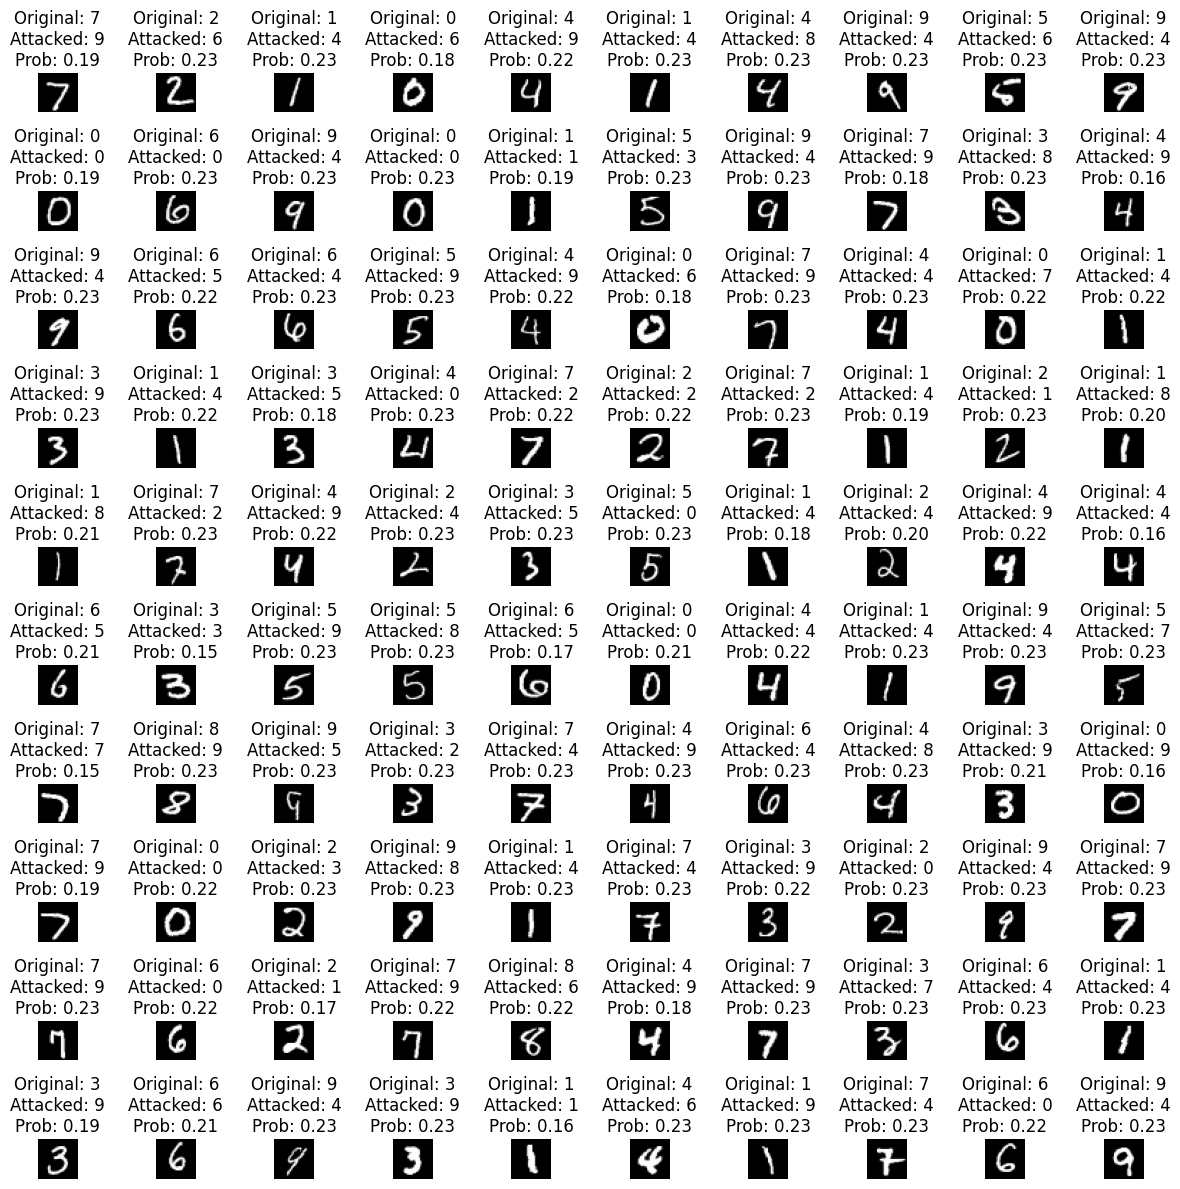

In [18]:

def visualize_jsma_attack(original_images, attacked_images, original_labels, attacked_labels, probs):
    num_images = len(original_images)
    num_rows = 10
    num_cols = 10
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i][j].imshow(original_images[index].reshape(28, 28), cmap='gray')
                axes[i][j].axis('off')
                axes[i][j].set_title(f'Original: {original_labels[index]}\nAttacked: {attacked_labels[index]}\nProb: {probs[index]:.2f}')
            else:
                axes[i][j].axis('off')
    plt.tight_layout()
    plt.show()
visualize_jsma_attack(x_test,adversarial_images,original_labels,attacked_labels,probs)

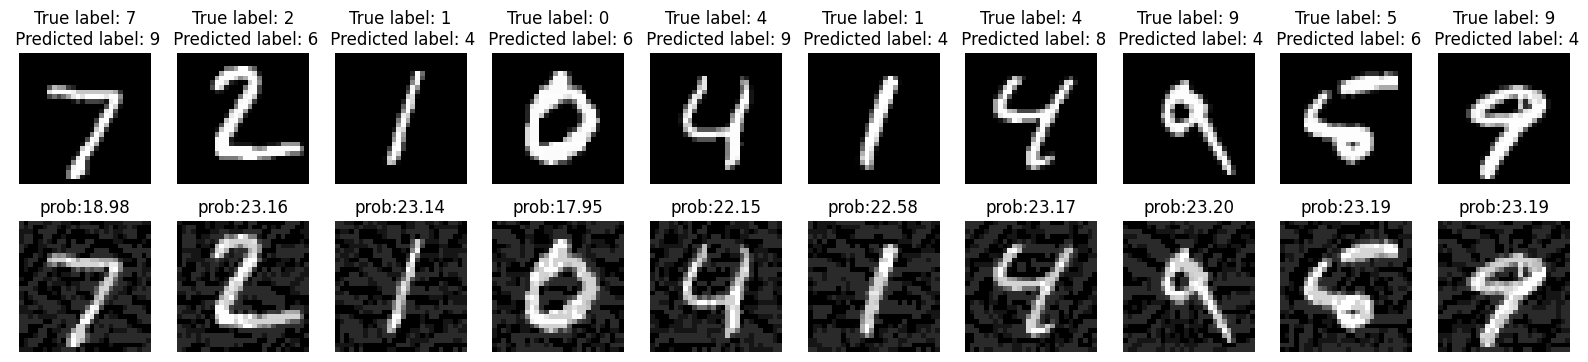

In [19]:
original_images=x_test
original_labels=y_test
perturbed_images=adversarial_images
probs=probs
# Find the misclassified images
misclassified_indices = []
for i in range(len(x_test)):
    if original_labels[i] != attacked_labels[i]:
        misclassified_indices.append(i)
        
# Visualize 10 misclassified original and perturbed images
num_images_to_visualize = 10
plt.figure(figsize=(20, 4))
for i in range(num_images_to_visualize):
    index = misclassified_indices[i]
    original_image = original_images[index].squeeze()
    # perturbed_image = adversarial_images[index].squeeze()
    perturbed_image = tf.squeeze(adversarial_images[index])

    true_label = original_labels[index]
    predicted_label = attacked_labels[index]
    probability = probs[index]
    # Show the original image
    plt.subplot(2, num_images_to_visualize, i+1)
    plt.imshow(original_image, cmap='gray')
    plt.title("True label: {}\n Predicted label: {}".format(true_label, predicted_label))
    plt.axis('off')
    # Show the perturbed image
    plt.subplot(2, num_images_to_visualize, num_images_to_visualize+i+1)
    plt.imshow(perturbed_image, cmap='gray')
    plt.title(f'prob:{np.max(np.round(probs[index]*100, 2)):.2f}')
    plt.axis('off')
plt.show()

In [20]:

def jsma_test(model, test_images, test_labels, epsilon=0.1, max_iters=100):
    # Generate adversarial examples using JSMA attack
    perturbed_images, true_labels, adv_labels, adv_probs = jsma_attack(model, test_images, test_labels, epsilon=epsilon, max_iters=max_iters)
    
    # Evaluate original test set accuracy
    original_loss, original_acc = model.evaluate(test_images, test_labels, verbose=0)
    
    # Evaluate attacked test set accuracy
    attacked_loss, attacked_acc = model.evaluate(perturbed_images, test_labels, verbose=0)
    
    # Return results
    return attacked_loss, original_acc, attacked_acc

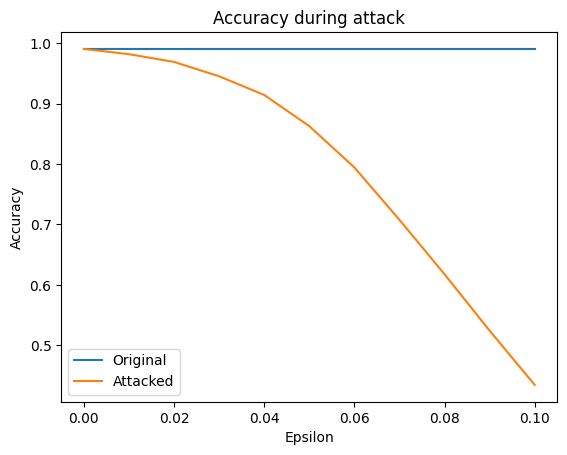

In [21]:
# Define a list of epsilon values to test
epsilons = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
# epsilons=[0.1]
# Initialize lists to store results
test_losses = []
accuracy_originals = []
accuracy_attackeds = []

# Loop over the epsilon values and calculate test loss and accuracy for each
for epsilon in epsilons:
    # Run the test function
    test_loss, accuracy_original, accuracy_attacked=jsma_test(model,x_test,y_test,epsilon, max_iters=2)
    # Append the results to the lists
    test_losses.append(test_loss)
    accuracy_originals.append(accuracy_original)
    accuracy_attackeds.append(accuracy_attacked)

# Convert the lists to numpy arrays for plotting
epsilons = np.array(epsilons)
test_losses = np.array(test_losses)
accuracy_originals = np.array(accuracy_originals)
accuracy_attackeds = np.array(accuracy_attackeds)

# Plot the graph
plt.plot(epsilons, accuracy_originals, label='Original')
plt.plot(epsilons, accuracy_attackeds, label='Attacked')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy during attack')
plt.legend()
plt.show()